***Option 1 : Suppression des NaN***

In [ ]:
data_clean = data_merged.dropna()

n_avant = len(data_merged)
n_apres = len(data_clean)
perte = n_avant - n_apres
pourcentage_perte = (perte / n_avant) * 100

print("\n--- Vérification des valeurs manquantes restantes ---")
missing_check = data_clean.isna().sum()
print(missing_check)
print(len(data_clean))


--- Vérification des valeurs manquantes restantes ---
Country                  0
Year                     0
Risk                     0
External_Debt_GDP        0
Debt_Service_Exports     0
GDP_Growth               0
Current_Account          0
Exchange_Rate            0
Corruption_Governance    0
Net_ODA_received         0
dtype: int64
545


***Option 2 : Traitement des valeurs manquantes***


Valeurs manquantes par année:
Year
2008     10
2009      9
2010      6
2011      8
2012      7
2013      8
2014      6
2015      6
2016      6
2017      8
2018      8
2019      5
2020      4
2021     10
2022     10
2023     15
2024    154
dtype: int64
         Country  Year      Risk  External_Debt_GDP  Debt_Service_Exports  \
16   Afghanistan  2008      HIGH          21.212132              0.402819   
15   Afghanistan  2009      HIGH          20.036725              0.487686   
14   Afghanistan  2010      HIGH          15.333497              0.379800   
13   Afghanistan  2011      HIGH          13.977052              0.323576   
12   Afghanistan  2012      HIGH          12.928160              0.598756   
..           ...   ...       ...                ...                   ...   
667     Zimbabwe  2020  DISTRESS          48.394048             18.681678   
666     Zimbabwe  2021  DISTRESS          51.903280              9.229217   
665     Zimbabwe  2022  DISTRESS          43.180954   

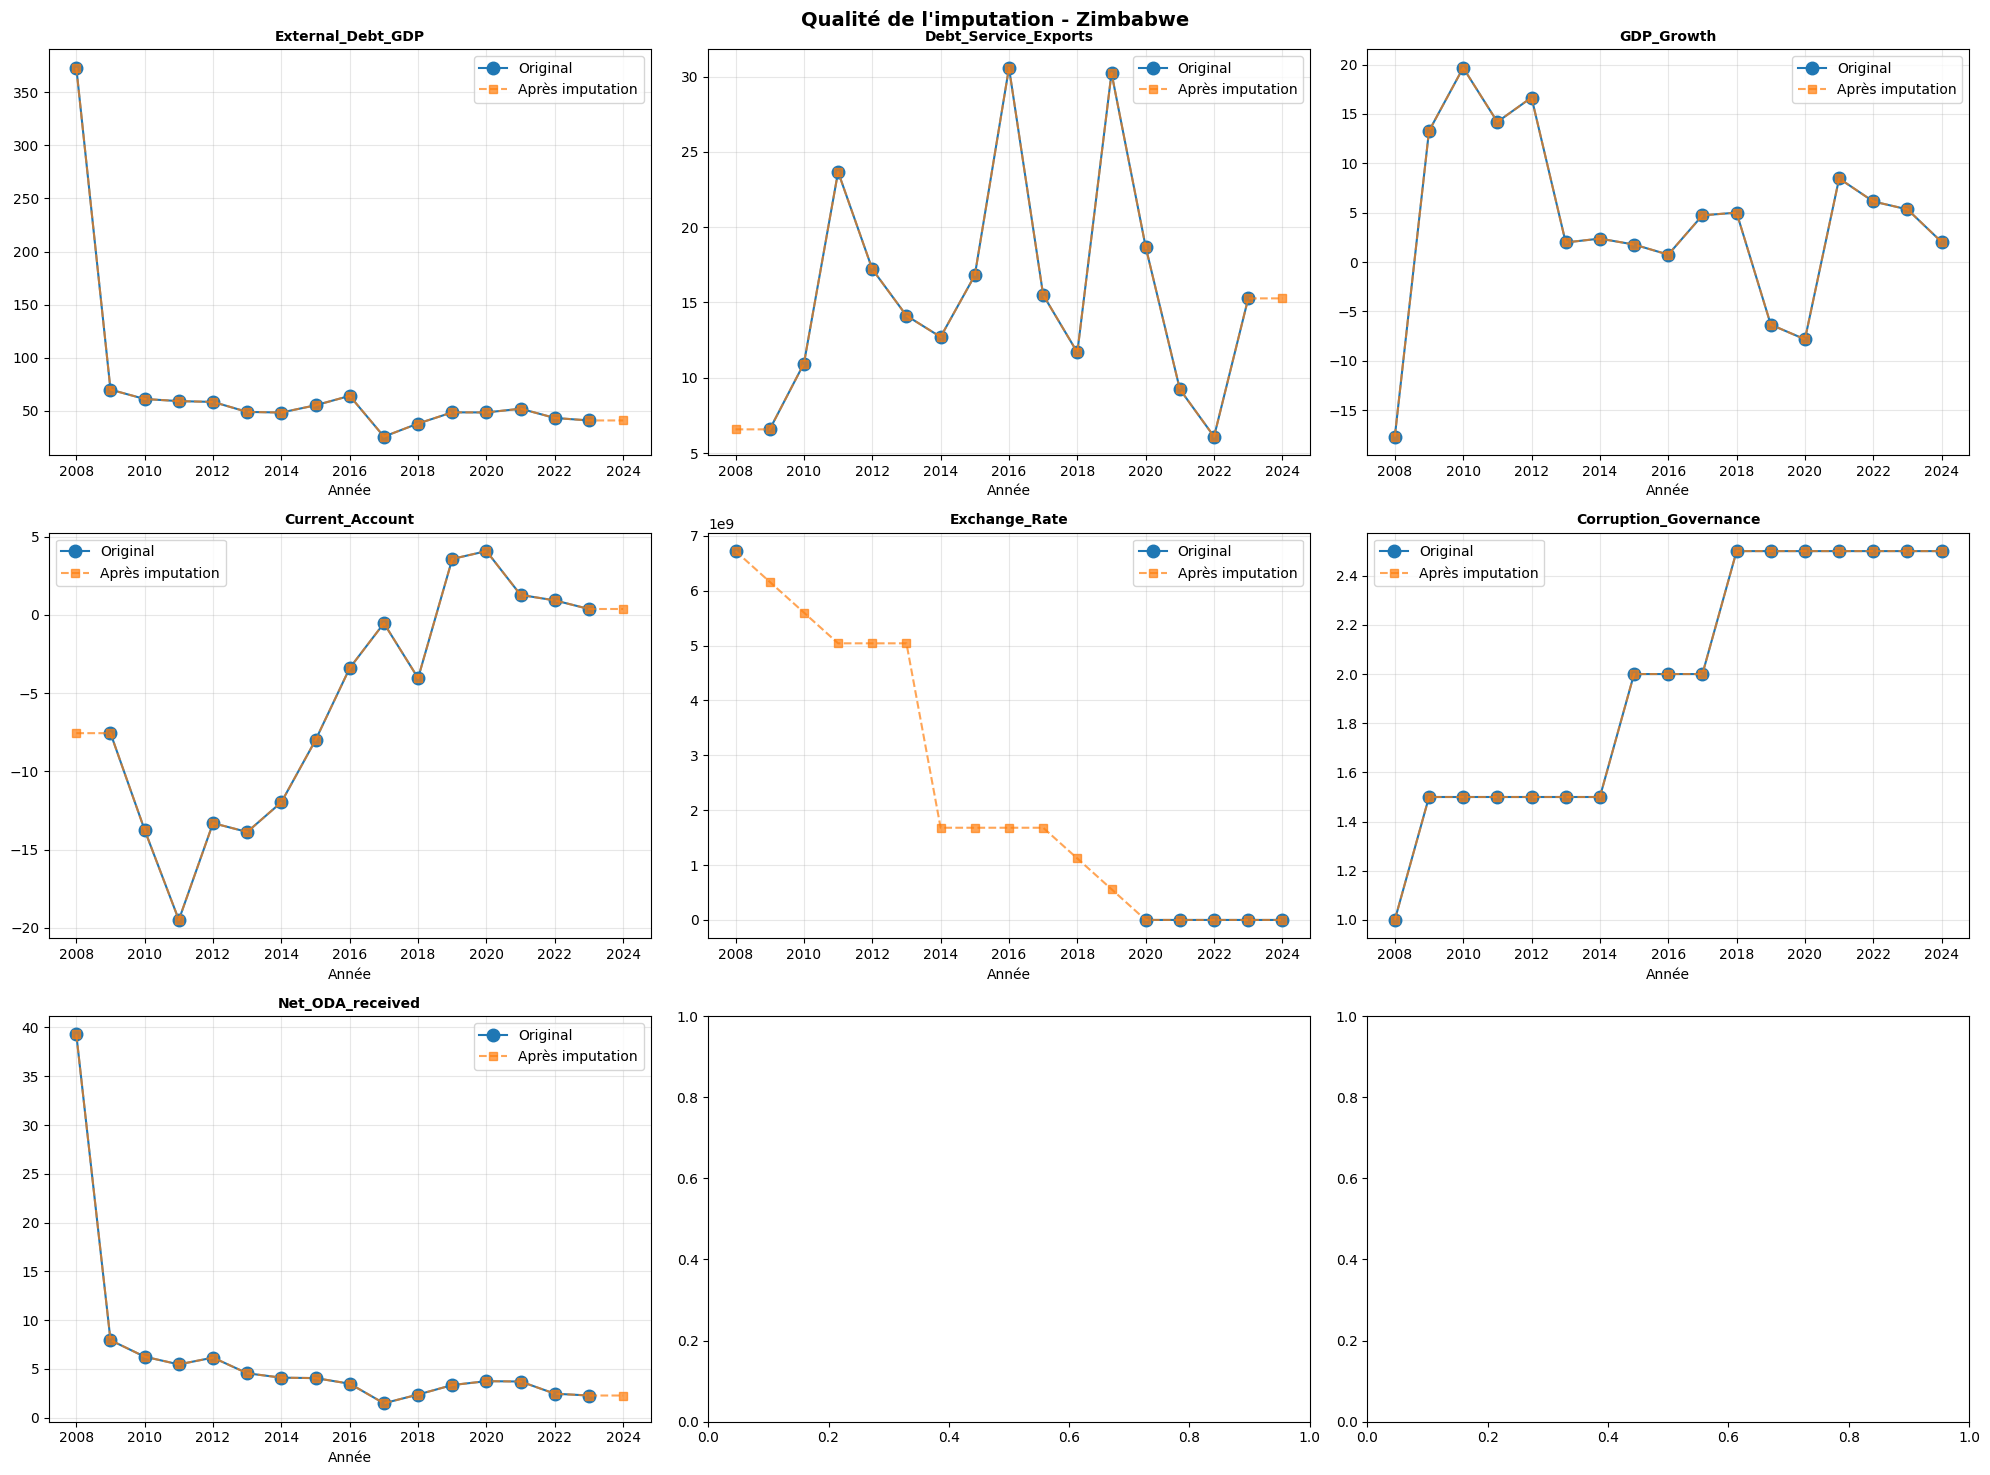

In [ ]:
df = data_merged.copy()

missing_by_country = df.groupby('Country').apply(
    lambda x: x.isnull().sum()
).sum(axis=1).sort_values(ascending=False)


missing_by_year = df.groupby('Year').apply(
    lambda x: x.isnull().sum()
).sum(axis=1)

print("\nValeurs manquantes par année:")
print(missing_by_year)

# Interpolation temporelle par pays

numeric_cols = ['External_Debt_GDP', 'Debt_Service_Exports', 'GDP_Growth',
                'Current_Account', 'Exchange_Rate',
                'Corruption_Governance', 'Net_ODA_received']

df = df.sort_values(['Country', 'Year'])

print(df)

for col in numeric_cols:
    df[col] = df.groupby('Country')[col].transform(
        lambda x: x.interpolate(method='linear', limit_direction='both', limit=3)
    )

missing_after_interpolation = df[numeric_cols].isnull().sum()
print("\nValeurs manquantes après interpolation temporelle:")
print(missing_after_interpolation)

for col in numeric_cols:
    df[col] = df.groupby('Country')[col].transform(
        lambda x: x.fillna(method='ffill', limit=2)
    )
    df[col] = df.groupby('Country')[col].transform(
        lambda x: x.fillna(method='bfill', limit=2)
    )

missing_after_fill = df[numeric_cols].isnull().sum()
print("\nValeurs manquantes après forward/backward fill:")
print(missing_after_fill)

# Imputation par médiane du pays

for col in numeric_cols:
    country_median = df.groupby('Country')[col].transform('median')
    df[col] = df[col].fillna(country_median)

missing_after_median = df[numeric_cols].isnull().sum()
print("\nValeurs manquantes après imputation par médiane du pays:")
print(missing_after_median)

# Imputation globale

for col in numeric_cols:
    global_median = df[col].median()
    df[col] = df[col].fillna(global_median)

final_missing = df[numeric_cols].isnull().sum()
print("\nValeurs manquantes finales:")
print(final_missing)


summary = pd.DataFrame({
    'Initial': data_merged[numeric_cols].isnull().sum(),
    'Après_Interpolation': missing_after_interpolation,
    'Après_Fill': missing_after_fill,
    'Après_Médiane': missing_after_median,
    'Final': final_missing
})
summary['Taux_Imputation_%'] = (
    (summary['Initial'] - summary['Final']) / summary['Initial'] * 100
).round(2)

print("\n", summary)



def plot_imputation_quality(original_df, cleaned_df, country='Kenya'):
    fig, axes = plt.subplots(3, 3, figsize=(20, 15))
    axes = axes.flatten()

    for idx, col in enumerate(numeric_cols):
        orig_data = original_df[original_df['Country'] == country].set_index('Year')[col]
        clean_data = cleaned_df[cleaned_df['Country'] == country].set_index('Year')[col]

        axes[idx].plot(orig_data.index, orig_data.values, 'o-', label='Original', markersize=9)
        axes[idx].plot(clean_data.index, clean_data.values, 's--',
                      label='Après imputation', alpha=0.7, markersize=6)
        axes[idx].set_title(col, fontsize=10, fontweight='bold')
        axes[idx].set_xlabel('Année')
        axes[idx].legend()
        axes[idx].grid(True, alpha=0.3)

    plt.suptitle(f'Qualité de l\'imputation - {country}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

plot_imputation_quality(data_merged, df, 'Zimbabwe')